In [4]:
import pandas as pd
import run_model


df = pd.read_csv('dls-100.csv')
df['solpred'] = [run_model.run_prediction(i)[0] for i in df['SMILES']]

Transformation Pipeline and Model Successfully Loaded
Transformation Pipeline and Model Successfully Loaded
Transformation Pipeline and Model Successfully Loaded
Transformation Pipeline and Model Successfully Loaded
Transformation Pipeline and Model Successfully Loaded
Transformation Pipeline and Model Successfully Loaded
Transformation Pipeline and Model Successfully Loaded
Transformation Pipeline and Model Successfully Loaded
Transformation Pipeline and Model Successfully Loaded
Transformation Pipeline and Model Successfully Loaded
Transformation Pipeline and Model Successfully Loaded
Transformation Pipeline and Model Successfully Loaded
Transformation Pipeline and Model Successfully Loaded
Transformation Pipeline and Model Successfully Loaded
Transformation Pipeline and Model Successfully Loaded
Transformation Pipeline and Model Successfully Loaded
Transformation Pipeline and Model Successfully Loaded
Transformation Pipeline and Model Successfully Loaded
Transformation Pipeline and 

,Unnamed: 0,Chemical name,Crystal structure CSD refcode,LogS exp (mol/L),Reference,Test,SMILES,Smiles Source,Chemspider reference number,InChl,cansmi,is_unique,solpred
0,1,Adenosine,ADENOS10,-1.73,2,False,c1nc(c2c(n1)n(cn2)[C@H]3[C@@H]([C@@H]([C@H](O3...,ChemSpider,54923,InChI=1S/C10H13N5O4/c11-8-5-9(13-2-12-8)15(3-1...,Nc1ncnc2c1ncn2C1OC(CO)C(O)C1O,True,-1.082449
1,2,Allopurinol,ALOPUR,-2.26,8,False,c1c2c([nH]n1)ncnc2O,ChemSpider,2010,InChI=1S/C5H4N4O/c10-5-3-1-8-9-4(3)6-2-7-5/h1-...,Oc1ncnc2[nH]ncc12,True,-1.921410
2,3,Trimethoprim,AMXBPM10,-2.95,3,False,COc1cc(cc(c1OC)OC)Cc2cnc(nc2N)N,ChemSpider,953,InChI=1S/C7H7NO2/c8-6-3-1-5(2-4-6)7(9)10/h1-4H...,COc1cc(Cc2cnc(N)nc2N)cc(OC)c1OC,True,-2.984431
3,5,Benzoic acid,BENZAC02,-1.58,8,False,c1ccc(cc1)C(=O)O,ChemSpider,5376,InChI=1S/C14H18N4O3/c1-19-10-5-8(6-11(20-2)12(...,O=C(O)c1ccccc1,True,-1.600015
4,6,Salbutamol,BHHPHE,-1.22,2,False,OCc1cc(ccc1O)C(O)CNC(C)(C)C,ChemSpider,2121,InChI=1S/C11H12N2O/c1-9-8-11(14)13(12(9)2)10-6...,CC(C)(C)NCC(O)c1ccc(O)c(CO)c1,True,-2.367498
5,7,Quinidine,BOMDUC,-2.81,2,False,O(c4cc1c(nccc1[C@H](O)[C@@H]2N3CC[C@@H](C2)[C@...,ChemSpider,1909,InChI=1S/C4H6N4O3S2/c1-2(9)6-3-7-8-4(12-3)13(5...,C=CC1CN2CCC1CC2C(O)c1ccnc2ccc(OC)cc12,True,-4.173007
6,10,(RS)-Atenolol,CEZVIN,-1.21,4,False,CC(C)NCC(COc1ccc(cc1)CC(=O)N)O,ChemSpider,389880,InChI=1S/C20H24N2O2/c1-3-13-12-22-9-7-14(13)10...,CC(C)NCC(O)COc1ccc(CC(N)=O)cc1,True,-2.353530
7,11,Chloral Hydrate,CHORLH01,1.70,2,False,ClC(Cl)(Cl)C(O)O,ChemSpider,2241,"InChI=1S/C7H7NO/c8-7(9)6-4-2-1-3-5-6/h1-5H,(H2...",OC(O)C(Cl)(Cl)Cl,True,-1.432315
8,12,Cimetidine,CIMETD,-1.69,3,False,Cc1c(nc[nH]1)CSCCN\C(=N\C)NC#N,ChemSpider,25315,"InChI=1S/C12H15Cl2NO5S/c1-21(19,20)8-4-2-7(3-5...",CN=C(NC#N)NCCSCc1nc[nH]c1C,True,-2.608387
9,14,Chlorprothixene,CMAPTX,-6.75,3,False,Clc2cc1C(\c3c(Sc1cc2)cccc3)=C/CCN(C)C,ChemSpider,2606,"InChI=1S/C2H3Cl3O2/c3-2(4,5)1(6)7/h1,6-7H",CN(C)CCC=C1c2ccccc2Sc2ccc(Cl)cc21,True,-5.852920


0.8055932623483771 7.038152544090271e-14


<AxesSubplot:xlabel='LogS exp (mol/L)', ylabel='solpred'>

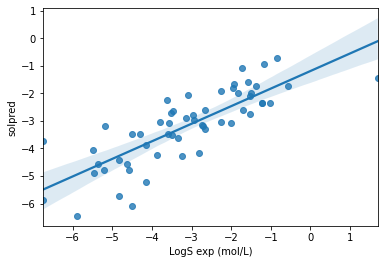

In [15]:
import seaborn as sns
from scipy.stats import pearsonr, norm

pearson_corr, p_val = pearsonr(df["LogS exp (mol/L)"], df["solpred"])
print(pearson_corr, p_val)
sns.regplot(x="LogS exp (mol/L)", y="solpred", data=df)

In [22]:
# stolen from https://github.com/PatWalters/solubility
import pandas as pd
from scipy.stats import norm, pearsonr
import math
import numpy as np
import matplotlib.pyplot as plt
plt.switch_backend("agg")


def pearson_confidence(r, num, interval=0.95):
    """
    Calculate upper and lower 95% CI for a Pearson r (not R**2)
    Inspired by https://stats.stackexchange.com/questions/18887
    :param r: Pearson's R
    :param num: number of data points
    :param interval: confidence interval (0-1.0)
    :return: lower bound, upper bound
    """
    stderr = 1.0 / math.sqrt(num - 3)
    z_score = norm.ppf(interval)
    delta = z_score * stderr
    lower = math.tanh(math.atanh(r) - delta)
    upper = math.tanh(math.atanh(r) + delta)
    return lower, upper


def calc_pearson(pred, truth):
    """
    Calculate a Pearson R**2 + confidence intervals for a set of predicted and true values
    :param pred: predicted values
    :param truth: true (experimental values)
    :return: Pearson R**2, lower and upper 95% confidence intervals
    """
    pearson_r_val = pearsonr(truth, pred)[0]
    lower, upper = pearson_confidence(pearson_r_val, len(pred))
    return [x ** 2 for x in [pearson_r_val, lower, upper]]


def eval_results(df, truth_col, col):
    """
    Read a csv file with solubility results
    Columns are SMILES, Name, True values, all subsequent columns are predictions
    Generates png files with R**2 and R**2 + confidence intervals
    :param infile_name: input file name
    :return: None
    """
    res = []
    r, lower, upper = calc_pearson(df[truth_col].values, df[col].values)
    res.append([col, r, lower, upper])
    df = pd.DataFrame(res, columns=["Method", "R**2", "Lower", "Upper"])
    print(df)
    draw_histogram(df, "Solubility Comparison", "solubility_comparison_error.png", "Method", "R**2", "Lower", "Upper")


def draw_histogram(input_df, title, outfile_name, name_col, val_col, lb_col=None, ub_col=None):
    """
    Draw a histogram, with error bars
    :param input_df: input dataframe
    :param title: Title for the plot
    :param outfile_name: output file name
    :param name_col: name to put on the x-axis
    :param val_col: value column to plot as the histogram
    :param ub_col: upper bound column
    :param lb_col: lower bound column
    :return: None
    """

    fig, ax = plt.subplots()

    xlab = input_df[name_col]
    y_val = input_df[val_col]

    if ub_col and lb_col:
        lb = y_val - input_df[lb_col].values
        ub = input_df[ub_col].values - y_val
    x_pos = np.arange(len(xlab))

    ax.set_title(title)
    ax.bar(x_pos, y_val, yerr=None, align='center', alpha=0.5)
    if lb_col:
        ax.errorbar(x_pos,y_val,yerr=[lb,ub],fmt="none",capsize=10,color='black')
    ax.set_ylabel(val_col)
    ax.set_xticks(x_pos)
    ax.set_xticklabels(xlab)
    ax.yaxis.grid(True)

    plt.tight_layout()
    # plt.savefig(outfile_name)

    Method      R**2     Lower     Upper
0  solpred  0.648981  0.504962  0.759931


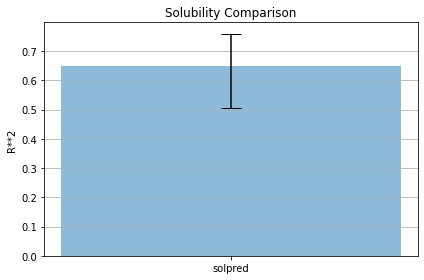

In [23]:
eval_results(df, "LogS exp (mol/L)" ,"solpred")